In [8]:
import pandas as pd

# Load the uploaded CSV file
file_path = "flat-ui__data-Thu Feb 27 2025.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand its structure
df.head()


,Date,Price
0,1833-01,18.93
1,1833-02,18.93
2,1833-03,18.93
3,1833-04,18.93
4,1833-05,18.93


In [9]:
# Convert the "Date" column to a datetime format and set it as the index
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m")
df.set_index("Date", inplace=True)

df.head()

,Price
Date,
1833-01-01,18.93
1833-02-01,18.93
1833-03-01,18.93
1833-04-01,18.93
1833-05-01,18.93


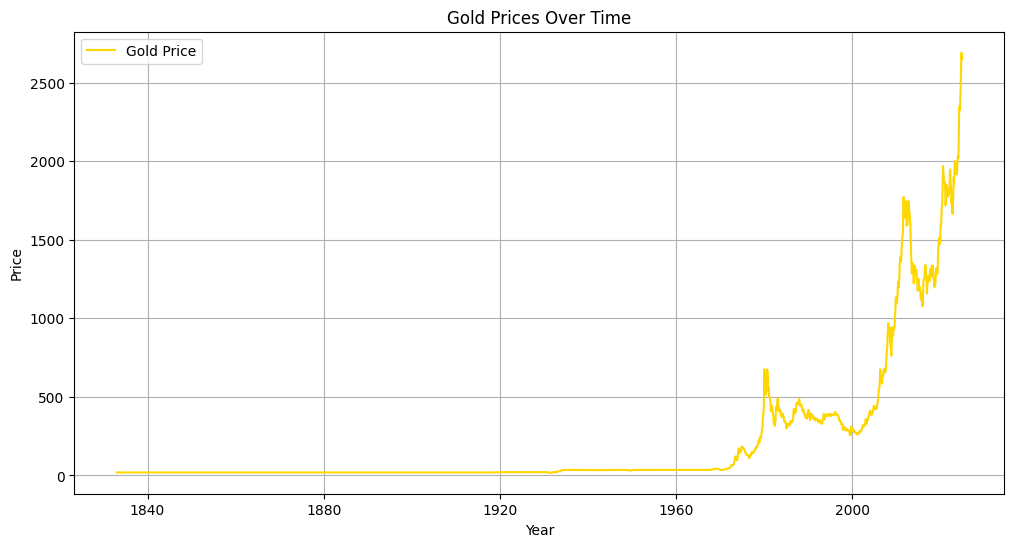

In [10]:
import matplotlib.pyplot as plt

# Plot the gold prices over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Gold Price", color='gold')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Gold Prices Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


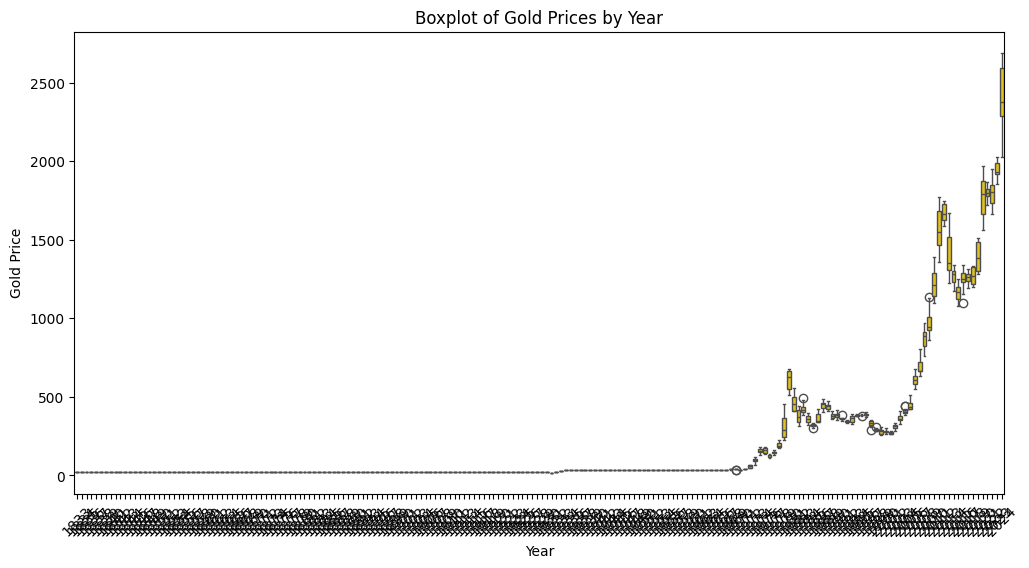

In [11]:
import seaborn as sns

# Extract year from the index
df["Year"] = df.index.year

# Create a boxplot of gold prices by year
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Year"], y=df["Price"], color="gold")

plt.xlabel("Year")
plt.ylabel("Gold Price")
plt.title("Boxplot of Gold Prices by Year")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


In [13]:
# Recreate the summaries correctly

# Create yearly summary
yearly_summary = df.resample('Y')['Price'].agg(['mean', 'median', 'min', 'max', 'std'])

# Create quarterly summary
quarterly_summary = df.resample('Q')['Price'].agg(['mean', 'median', 'min', 'max', 'std'])

# Create decade summary
df["Decade"] = (df.index.year // 10) * 10  # Grouping years into decades
decade_summary = df.groupby("Decade")['Price'].agg(['mean', 'median', 'min', 'max', 'std'])

df.head()

,Price,Year,Decade
Date,,,
1833-01-01,18.93,1833,1830
1833-02-01,18.93,1833,1830
1833-03-01,18.93,1833,1830
1833-04-01,18.93,1833,1830
1833-05-01,18.93,1833,1830


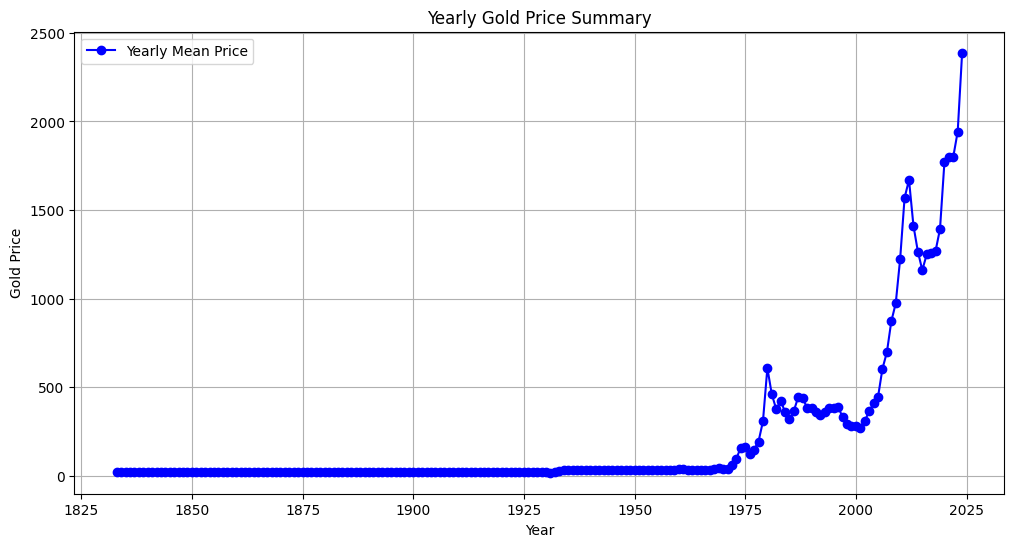

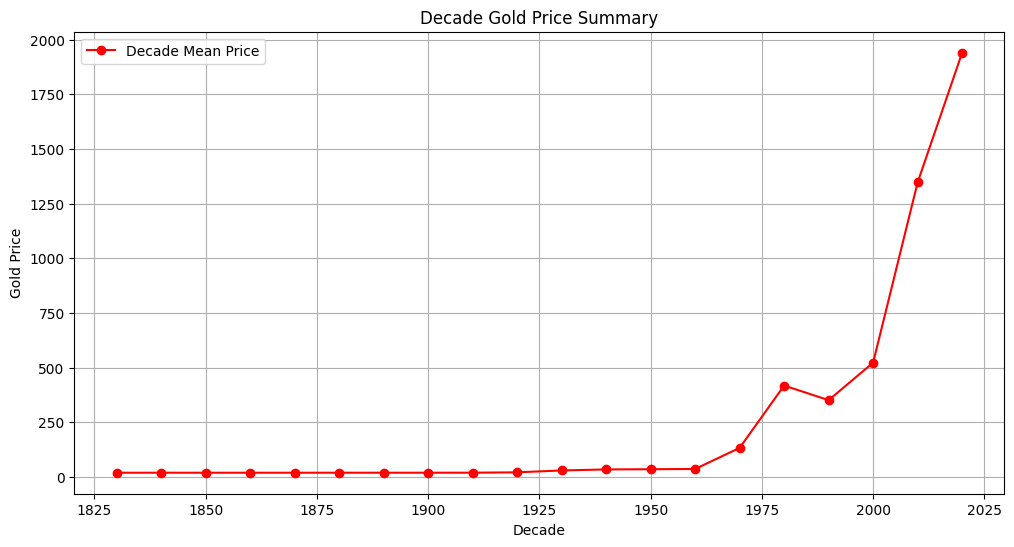

In [15]:
# Convert yearly summary index to integer directly
if isinstance(yearly_summary.index, pd.DatetimeIndex):
    yearly_summary.index = yearly_summary.index.year

# Convert decade summary index to integer
decade_summary.index = decade_summary.index.astype(int)

# Yearly Summary Plot
plt.figure(figsize=(12, 6))
plt.plot(yearly_summary.index, yearly_summary['mean'], label="Yearly Mean Price", color='blue', marker='o')
plt.xlabel("Year")
plt.ylabel("Gold Price")
plt.title("Yearly Gold Price Summary")
plt.legend()
plt.grid(True)
plt.show()

# Decade Summary Plot
plt.figure(figsize=(12, 6))
plt.plot(decade_summary.index, decade_summary['mean'], marker='o', linestyle='-', label="Decade Mean Price", color='red')
plt.xlabel("Decade")
plt.ylabel("Gold Price")
plt.title("Decade Gold Price Summary")
plt.legend()
plt.grid(True)
plt.show()


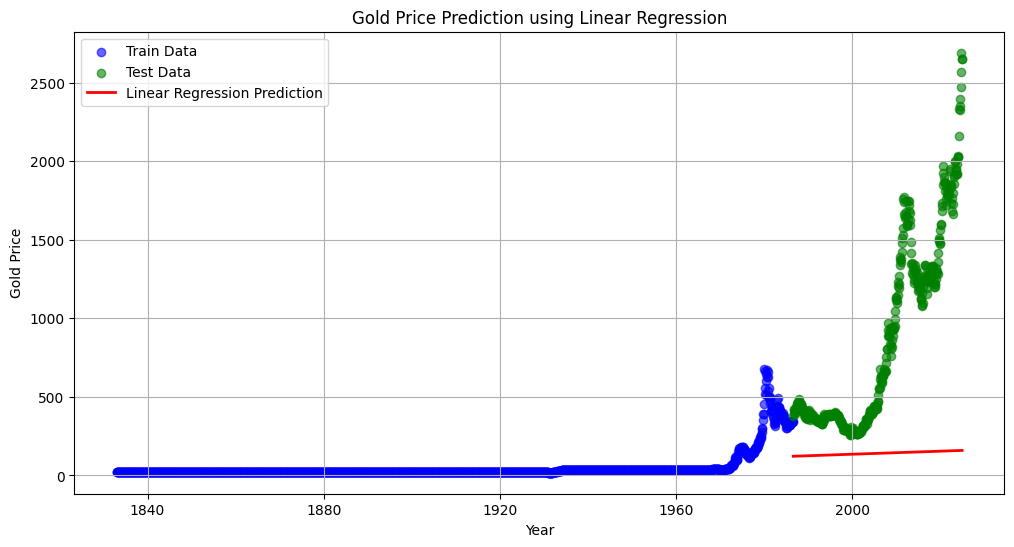

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data: Convert dates to numerical values (number of months since start)
df["Time"] = (df.index.year - df.index.year.min()) * 12 + df.index.month

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define independent (X) and dependent (y) variables
X_train = train_data["Time"].values.reshape(-1, 1)
y_train = train_data["Price"].values
X_test = test_data["Time"].values.reshape(-1, 1)
y_test = test_data["Price"].values

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Plot train data, test data, and predictions
plt.figure(figsize=(12, 6))
plt.scatter(train_data.index, train_data["Price"], label="Train Data", color="blue", alpha=0.6)
plt.scatter(test_data.index, test_data["Price"], label="Test Data", color="green", alpha=0.6)
plt.plot(test_data.index, y_pred, label="Linear Regression Prediction", color="red", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction using Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Define Mean Absolute Percentage Error (MAPE) function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for the model
mape = mean_absolute_percentage_error(y_test, y_pred)

# Display the MAPE value
mape


75.17662345756516

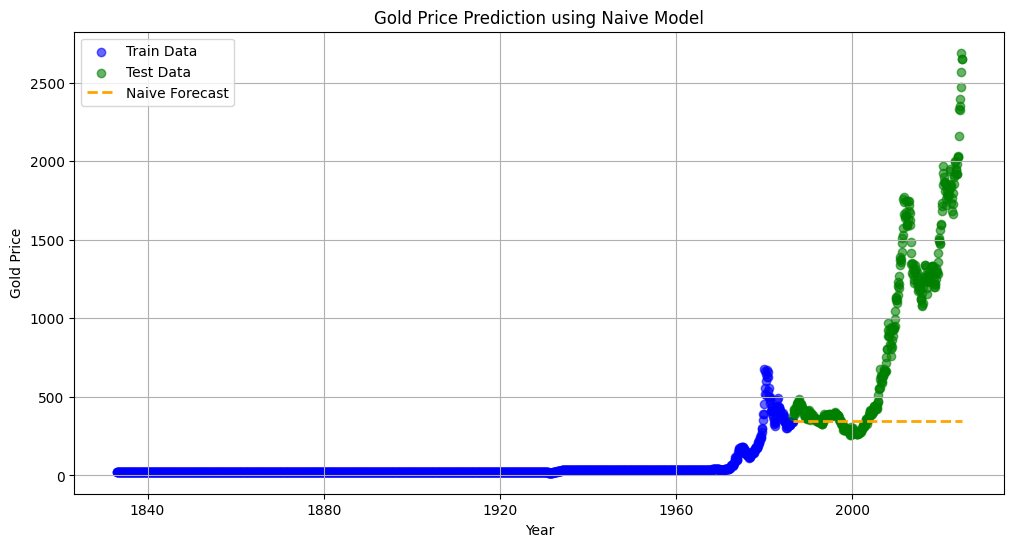

In [24]:
# Create a naive model (using the last observed value as the forecast)
naive_forecast = np.full_like(y_test, train_data["Price"].iloc[-1])

# Plot train data, test data, and naive forecast
plt.figure(figsize=(12, 6))
plt.scatter(train_data.index, train_data["Price"], label="Train Data", color="blue", alpha=0.6)
plt.scatter(test_data.index, test_data["Price"], label="Test Data", color="green", alpha=0.6)
plt.plot(test_data.index, naive_forecast, label="Naive Forecast", color="orange", linewidth=2, linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction using Naive Model")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Since the naive model performed better, we'll use it for forecasting.
# Extend the time range for forecasting
future_time = np.arange(df["Time"].max() + 1, df["Time"].max() + 13)  # Forecast for next 12 months

# Generate naive forecast (last observed value)
naive_forecast_future = np.full_like(future_time, df["Price"].iloc[-1])

# Create a dataframe to store the predictions and confidence intervals
forecast_df = pd.DataFrame({
    "Time": future_time,
    "Predicted Price": naive_forecast_future,
    "Lower Bound": naive_forecast_future * 0.95,  # Assuming a 5% confidence interval
    "Upper Bound": naive_forecast_future * 1.05
})

# Convert time back to datetime format
forecast_df["Date"] = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Set Date as index
forecast_df.set_index("Date", inplace=True)

forecast_df.head()


,Time,Predicted Price,Lower Bound,Upper Bound
Date,,,,
2025-01-31,2305,2648,2515.6,2780.4
2025-02-28,2306,2648,2515.6,2780.4
2025-03-31,2307,2648,2515.6,2780.4
2025-04-30,2308,2648,2515.6,2780.4
2025-05-31,2309,2648,2515.6,2780.4


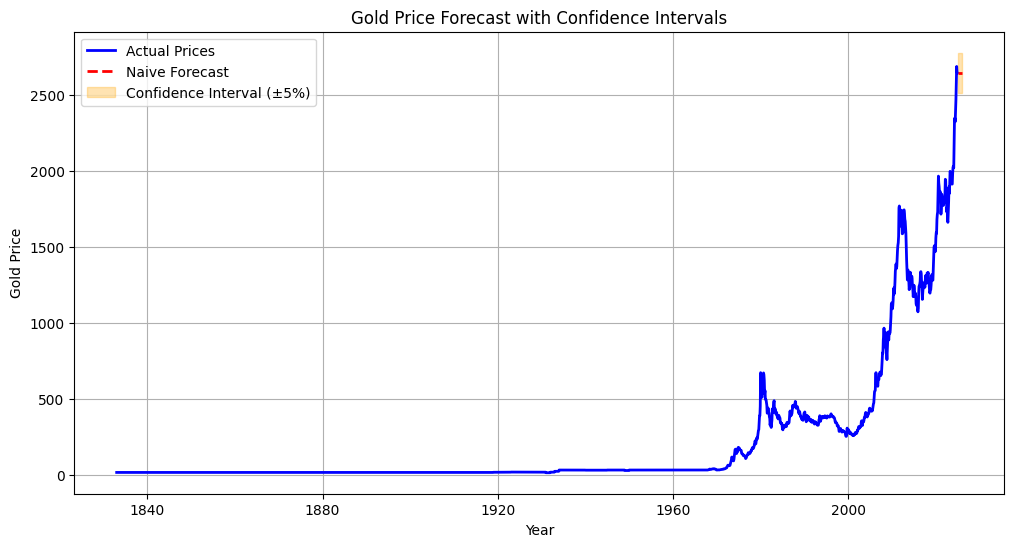

In [30]:
# Re-attempting to plot with confidence intervals
plt.figure(figsize=(12, 6))

# Plot historical prices
plt.plot(df.index, df["Price"], label="Actual Prices", color="blue", linewidth=2)

# Plot predicted prices
plt.plot(forecast_df.index, forecast_df["Predicted Price"], label="Naive Forecast", color="red", linestyle="dashed", linewidth=2)

# Convert confidence interval columns to float explicitly to avoid any issues
lower_bound = forecast_df["Lower Bound"].astype(float)
upper_bound = forecast_df["Upper Bound"].astype(float)

# Plot confidence intervals
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color="orange", alpha=0.3, label="Confidence Interval (±5%)")

plt.xlabel("Year")
plt.ylabel("Gold Price")
plt.title("Gold Price Forecast with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()
